# Part 4: Meta-training with GradientLearner

In [10]:
import numpy as np
import jax.numpy as jnp
import jax
from matplotlib import pylab as plt

from learned_optimization.outer_trainers import full_es
from learned_optimization.outer_trainers import truncated_pes
from learned_optimization.outer_trainers import gradient_learner
from learned_optimization.outer_trainers import truncation_schedule

from learned_optimization.tasks import quadratics
from learned_optimization.tasks.fixed import image_mlp
from learned_optimization.tasks import base as tasks_base

from learned_optimization.learned_optimizers import base as lopt_base
from learned_optimization.learned_optimizers import mlp_lopt
from learned_optimization.optimizers import base as opt_base

from learned_optimization import optimizers
from learned_optimization import training
from learned_optimization import eval_training

import haiku as hk
import tqdm

In this notebook we build upon the previous notebook which discussed `TruncationSchedule` and `GradientEstimator`. Here, we leverage these components to provide more complete training functionality.
We do not provide a full fledged training program -- only the computations that would need to be performed each iteration of meta-training.

This code is **not** the only way to use the previous abstractions but can be convenient to avoid writing the same code over and over again. We encourage readers to write their own meta-training loops before diving into these abstractions.

## Single machine meta-training: `SingleMachineGradientLearner`

The `SingleMachineGradientLearner` provides the functionality to meta-train a learned optimizer with one or more gradient estimator. As an example, let's train a learned optimizer leveraging gradients from 2 different tasks: a quadratic task, and a fashion mnist mlp.

In [11]:
theta_opt = opt_base.Adam(1e-3)

lopt = mlp_lopt.MLPLOpt()
max_length = 300
trunc_sched = truncation_schedule.LogUniformLengthSchedule(
    min_length=100, max_length=max_length)


def grad_est_fn(task_family):
  return truncated_pes.TruncatedPES(
      task_family=task_family,
      learned_opt=lopt,
      trunc_sched=trunc_sched,
      num_tasks=4,
      trunc_length=50,
      random_initial_iteration_offset=max_length)


mlp_task_family = tasks_base.single_task_to_family(
    image_mlp.ImageMLP_FashionMnist8_Relu32())

gradient_estimators = [
    grad_est_fn(quadratics.FixedDimQuadraticFamily(10)),
    grad_est_fn(mlp_task_family),
]

outer_trainer = gradient_learner.SingleMachineGradientLearner(
    lopt, gradient_estimators, theta_opt)

To use this, we must first construct the initial state which contains a randomly initialized learned optimizer, as well as all the initial state of all the inner-problems (in this case, one set for the quadratics being trained, and the other from the MLP being trained).

In [12]:
key = jax.random.PRNGKey(0)
outer_trainer_state = outer_trainer.init(key)
jax.tree_map(lambda x: jnp.asarray(x).shape, outer_trainer_state)

  lax._check_user_dtype_supported(dtype, "asarray")


SingleMachineState(gradient_learner_state=GradientLearnerState(theta_opt_state=OptaxState(params={'mlp/~/linear_0': {'b': (32,), 'w': (19, 32)}, 'mlp/~/linear_1': {'b': (32,), 'w': (32, 32)}, 'mlp/~/linear_2': {'b': (2,), 'w': (32, 2)}}, state=None, optax_opt_state=(ScaleByAdamState(count=(), mu={'mlp/~/linear_0': {'b': (32,), 'w': (19, 32)}, 'mlp/~/linear_1': {'b': (32,), 'w': (32, 32)}, 'mlp/~/linear_2': {'b': (2,), 'w': (32, 2)}}, nu={'mlp/~/linear_0': {'b': (32,), 'w': (19, 32)}, 'mlp/~/linear_1': {'b': (32,), 'w': (32, 32)}, 'mlp/~/linear_2': {'b': (2,), 'w': (32, 2)}}), EmptyState()), iteration=())), gradient_estimator_states=[PESWorkerState(pos_state=SingleState(inner_opt_state=MLPLOptState(params=(4, 10), rolling_features=MomAccumulator(m=(4, 10, 6), t=(4, 6)), iteration=(4,), state=None), inner_step=(4,), truncation_state=ConstantTruncationState(length=(4,)), task_param=(4, 10), is_done=(4,)), neg_state=SingleState(inner_opt_state=MLPLOptState(params=(4, 10), rolling_features=

This SingleMachineState contains the state of the `gradient_learner` (or the weights of the learned optimizer being trained as well as any variables needed to train these weights such as momentums (`theta_opt_state`).
It also contains the `gradient_estimator_states` which is a list containing the states of each gradient estimator.

We can train a single meta-step as follows. Note this could take a few minutes to compile.

In [13]:
next_state, loss, metrics = outer_trainer.update(
    outer_trainer_state, key, with_metrics=False)

  lax._check_user_dtype_supported(dtype, "asarray")


Now let's meta-train a few steps and watch the meta-loss go down.

In [14]:
losses = []
import tqdm

import os
# Pulling this from an environment variable so this file can be tested.
outer_train_steps = int(os.environ.get("LOPT_META_TRAIN_LENGTH", 500))

for i in tqdm.trange(outer_train_steps):
  outer_trainer_state, loss, metrics = outer_trainer.update(
      outer_trainer_state, key, with_metrics=False)
  losses.append(loss)

100%|██████████| 500/500 [00:31<00:00, 15.69it/s]


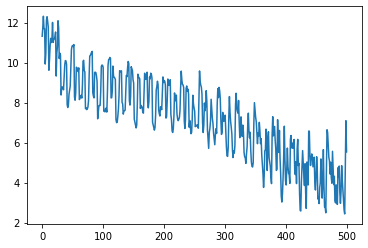

In [15]:
plt.plot(losses)

In [16]:
metrics

{'none||best_of_mean_loss': DeviceArray(5.5384226, dtype=float32),
 'none||mean_loss': DeviceArray(5.5384226, dtype=float32)}

We see some oscillations in this loss value. This makes sense as we are meta-training with a truncated method. Depending on the location in the inner-problem the losses will be greater or smaller. With enough tasks this will average out, but often this is not required to obtain performant learned optimizers. This does mean, however, that evaluating a learned optimizer after the fact is important to obtain a realistic performance measurement.

## Manual meta-gradient aggregation with applications to distributed training

Often when training a learned optimizer we seek to estimate meta-gradients over a wide variety of tasks spread across a number of different machines.
To do this we need to be explicit about what data needs to be sent from the central learner to compute updates (usually just the weights of the learned optimizer) and what data needs to be sent back (aggregated gradients + metrics and **not** the state of the unrolls for each inner-problem.)

To help manage this, we provide a class to manage the central learner's computation, and a function to compute updates which would run on each worker.


As this demo is in a colab, we will do everything in one process.
First, we will create the central learner. This is responsible for taking in gradients, updating the weights of the learned optimizer, and providing new data back to the workers.

In [73]:
theta_opt = opt_base.Adam(1e-3)
central_learner = gradient_learner.GradientLearner(lopt, theta_opt)

In [74]:
key = jax.random.PRNGKey(0)
central_state = central_learner.init(key)
jax.tree_map(lambda x: jnp.asarray(x).shape, central_state)

GradientLearnerState(theta_opt_state=OptaxState(params={'mlp/~/linear_0': {'b': (32,), 'w': (19, 32)}, 'mlp/~/linear_1': {'b': (32,), 'w': (32, 32)}, 'mlp/~/linear_2': {'b': (2,), 'w': (32, 2)}}, state=None, optax_opt_state=(ScaleByAdamState(count=(), mu={'mlp/~/linear_0': {'b': (32,), 'w': (19, 32)}, 'mlp/~/linear_1': {'b': (32,), 'w': (32, 32)}, 'mlp/~/linear_2': {'b': (2,), 'w': (32, 2)}}, nu={'mlp/~/linear_0': {'b': (32,), 'w': (19, 32)}, 'mlp/~/linear_1': {'b': (32,), 'w': (32, 32)}, 'mlp/~/linear_2': {'b': (2,), 'w': (32, 2)}}), EmptyState()), iteration=()))

We can see here that this just contains the weights of the learned optimizer, plus the extra accumulators used by adam.

Next, we can compute gradient estimators, but first we must get the required state from the learner.

In [75]:
worker_weights = central_learner.get_state_for_worker(central_state)

Next, we can compute gradients on a given worker. As before we need to get a list of gradient estimators. We can use the same set we used before.

In [76]:
max_length = 300
trunc_sched = truncation_schedule.LogUniformLengthSchedule(
    min_length=100, max_length=max_length)


def grad_est_fn(task_family):
  return truncated_pes.TruncatedPES(
      task_family=task_family,
      learned_opt=lopt,
      trunc_sched=trunc_sched,
      num_tasks=16,
      trunc_length=50,
      random_initial_iteration_offset=max_length)


mlp_task_family = tasks_base.single_task_to_family(
    image_mlp.ImageMLP_FashionMnist8_Relu32())

gradient_estimators = [
    grad_est_fn(quadratics.FixedDimQuadraticFamily(10)),
    grad_est_fn(mlp_task_family)
]

Next, we need to kick things off by first computing the initial states for each of the gradient estimators.

In [77]:
unroll_states = [
    grad.init_worker_state(worker_weights, key=jax.random.fold_in(key, i))
    for (i, grad) in enumerate(gradient_estimators)
]

  lax._check_user_dtype_supported(dtype, "asarray")


Next we can use these states to estimate a meta-gradient!

In [78]:
out = gradient_learner.gradient_worker_compute(
    worker_weights,
    gradient_estimators,
    unroll_states,
    key=key,
    with_metrics=False)

  lax._check_user_dtype_supported(dtype, "asarray")


This produces a couple of different outputs bundled together in a dataclass.

In [79]:
[x for x in dir(out) if not x.startswith("__") and x != "replace"]

['event_info', 'metrics', 'to_put', 'unroll_states']

Most importantly we have `to_put` which contains information that should be sent to the central learner, and `unroll_states` which contains the next unroll states.

Now with more than one worker, we would pass back a list of these gradients. In this demo, we will just use a single one, and pass this directly into the central learner to get the next meta-iteration. With more workers, this would contain a different gradient estimator from each worker.

In [80]:
grads_list = [out.to_put]
central_state, metrics = central_learner.update(central_state, grads_list)

And we can do this over and over again. This time let's do it with more than one gradient estimate.

In [81]:
losses = []

outer_train_steps = int(os.environ.get("LOPT_META_TRAIN_LENGTH", 500))

for i in tqdm.trange(outer_train_steps):
  worker_weights = central_learner.get_state_for_worker(central_state)

  key1, key = jax.random.split(key)
  out = gradient_learner.gradient_worker_compute(
      worker_weights,
      gradient_estimators,
      unroll_states,
      key=key1,
      with_metrics=False)
  # extract the next unroll state output for the next iteration.
  unroll_states = out.unroll_states

  central_state, metrics = central_learner.update(central_state, [out.to_put])
  losses.append(out.to_put.mean_loss)

100%|██████████| 500/500 [01:02<00:00,  8.06it/s]


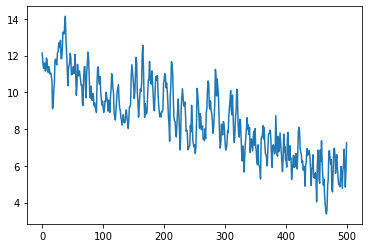

In [82]:
plt.plot(losses)